In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stat
import corner
import copy as COPY

%matplotlib nbagg
%matplotlib inline
np.random.seed(1)
plt.style.use('ggplot')
import numba as num

In [22]:
def Model_cubic(thetas,x):
    a = thetas[0]
    b = thetas[1]
    c = thetas[2]
    d = thetas[3]
    y_ii = a*x**3 + b*x**2 + c*x + d
    return y_ii

def prior_transform(u = None):
    a = 15.0*u[0]
    b = 15.0*u[1]
    c = 15.1*u[2]
    d = 15.0*u[3]
    return np.array([a,b,c,d])

def Likelihood(y=None,sigma=None,mu=None):
    term1 = -1*np.log(2*np.pi*(sigma**2))
    term2 = ((y-mu)**2)/(2*sigma**2)
    return sum((term1-term2))

def plus(x,y):
    if x>y:
        return x+np.log(1+np.exp(y-x))
    
    else:
        return y+np.log(1+np.exp(x-y))

In [23]:
Data_cubic = pd.read_csv('example_cubic_data.txt',delimiter=' ',names=['x','y','err'])
x_values_cubic = Data_cubic.x
y_values_cubic = Data_cubic.y
error_cubic = Data_cubic.err

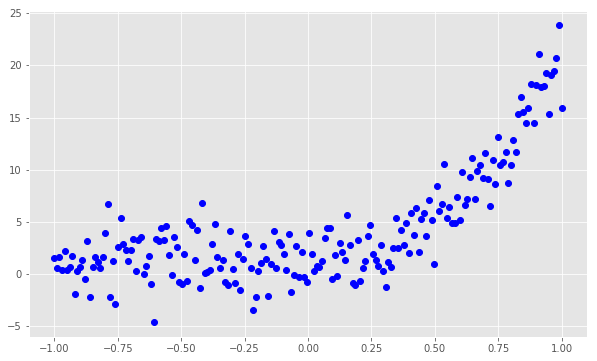

In [24]:
plt.figure(figsize=(10,6))
plt.plot(x_values_cubic,y_values_cubic,'o',color='blue')

In [25]:
n = 200  # Number of live points
ndim = 4
objects = np.zeros((n,ndim))
live_objects = np.zeros((n))

for i in range(n):
    objects[i,:] = prior_transform(u =  np.random.uniform(0,0.6,size=ndim))
    assert objects[i,:].shape == (4,)
    live_objects[i] = Likelihood(y=y_values_cubic,sigma=error_cubic,mu=Model_cubic(objects[i,:],x_values_cubic))

In [26]:
live_objects

array([-1052.30407796, -1587.99958197,  -990.26823679, -1003.01559055,
       -1264.60383644, -1139.9110048 , -2020.26188303, -1386.89014174,
        -850.91359512,  -896.69864579, -1223.09765844, -1066.11453548,
       -1183.09636543, -1190.66297519, -1731.98594245,  -801.08827966,
       -1293.26763508, -1123.88722315, -1379.31643802, -1505.87595951,
       -1276.4220812 ,  -850.02914131, -1244.983314  ,  -849.26710781,
       -1074.33621478, -1590.03839831, -1139.73211823, -1198.4663192 ,
        -885.26441058, -1189.80371139, -1210.79858323, -1352.4679097 ,
       -1917.18527299,  -868.38927298,  -913.18031691, -1293.75541336,
       -1613.21488499, -1746.23920057, -1507.57092772,  -996.40611684,
       -1148.47533282,  -801.11670917, -1164.16126617, -1142.81175621,
       -1176.15301079,  -978.54217646,  -813.72250214,  -854.05723192,
       -1657.14503461, -1140.66960381, -1234.99105604,  -891.99197698,
       -1519.82902852, -1939.62940936, -1109.93622987, -1214.94275674,
      

In [62]:
nest = 1000
keep = np.zeros((nest,ndim))
logl_sample = []     #Store Log-likelihood of samples
X_sample = []        #Store prior mass
   


logWT = []  #Store  weight =width*likelihood


logZ = -1e300     # SUM(weights)= Z Evidence
H = 0


In [63]:
# Defined intervals for each parameters
Flat_interval = [(0,10),(0,11),(0,12),(0,10)]
mcmc_steps = 100

In [64]:
## MAIN NS LOOP##
accept = 0
reject = 0
#Outer interval 
logw = np.log(1.0 - np.exp(-1.0 / n))

for i in range(nest):
    # Draw worst object with L* from n points
    worst = np.argmin(live_objects)
    
    #Save worst opbject
    keep[i,:] = objects[worst,:]
    logl_sample.append(live_objects[worst])
    
    #Save prior mass
    X_sample.append(logw)
    
    #Weight
    logwt = logw + live_objects[worst]
    
    
    #Save weight
    logWT.append(logwt)
    
    #Update Evidence Z
    logZnew = plus(logZ,logwt)  
    
    #Update H information
    H = np.exp(logwt-logZnew)*live_objects[worst] \
    +np.exp(logZ-logZnew)*(H+logZ)-logZnew
    
    #Update logZ
    logZ = logZnew
    #Shrink interval
    logw -= 1.0/n 
    

    while True:#----copy a random point and do mcmc from there-----
        copy = np.random.randint(len(objects))
        if (copy != worst):break
            
    objects[worst,:] = COPY.deepcopy(objects[copy,:])
    Likelihood_thresh =  live_objects[copy]

    theta = objects[copy,:]
    
    #UNIT TEST check for correct shape
    assert theta.shape == (4,)
    
    scale = 1.0
    for i in range(mcmc_steps):  #Evolve within current worst likelihood L>L* , draw new point under constraint
        
        propose_step = np.random.uniform(0,scale,size=ndim)
        new_point = theta + np.random.uniform(0,scale,size=ndim)
        
        
        add = 0
        for j in range(len(theta)):
                if Flat_interval[j][0] <= new_point[j] <= Flat_interval[j][1]:
                    add += 1
                else:
                    pass

        if add == len(theta):
            Prior = 1
        else:
            Prior = 0
        
        Likelihood_new = Likelihood(y=y_values_cubic,sigma=error_cubic,mu=Model_cubic(new_point,x_values_cubic))+np.log(Prior)
    
        #Acceptance ratio alpha
        logalpha = Likelihood_new-Likelihood_thresh
        alpha = np.exp(logalpha)
        
        if alpha>=1:
            objects[worst,:] = new_point  #Replace worst point with new point
            live_objects[worst] = Likelihood_new   #Replace the worst likelihood with new one  
            accept += 1
            
        else:
            u = np.random.uniform()
            if u <= alpha :
                objects[worst,:] = new_point 
                live_objects[worst] = Likelihood_new
                accept += 1
                
            else:
                u = u
                reject +=1
                
        #Changing the scale
        if accept > reject:
            scale *= np.exp(1./accept)
        if accept < reject:
            scale /= np.exp(1./reject)

    
    
                
    if i >nest*np.exp(H)/np.log(2.):
        break
        

Z = logZ
Z_err = np.sqrt((H)/n)
H = H        #np.exp(H)/np.log(2.)
Acceptance_Ratio = accept/(accept+reject)
print("Acceptance Ratio :",Acceptance_Ratio)
print('Evidence Z = {0} +-{1} : Information H = {2} '.format(Z,Z_err,H))

/home/hope-moloko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log


Acceptance Ratio : 0.19377
Evidence Z = 484.32995798999013 +-0.18627898948036067 : Information H = 6.939972384364864 


In [65]:
#Normalized samples
wt = np.exp((logWT)-max(logWT))
Weights = wt/sum(wt)

#Effective sample size
effective_sample_size = int(np.exp(-np.sum(Weights*np.log(Weights+1e-300))))
S = 0
sample = np.zeros((effective_sample_size,ndim))

# Selecting the Effective sample
while True:
    rnd_point = np.random.randint(len(keep))
    #proba = prob_weighted[rnd_point]/max(prob_weighted)
    proba = Weights[rnd_point]/max(Weights)
    
    if np.random.rand() < proba:
        sample[S,:] = keep[rnd_point,:]
        S += 1
    if S >= effective_sample_size:
        break
print('Effective Sample Size : {}'.format(effective_sample_size))

Effective Sample Size : 27


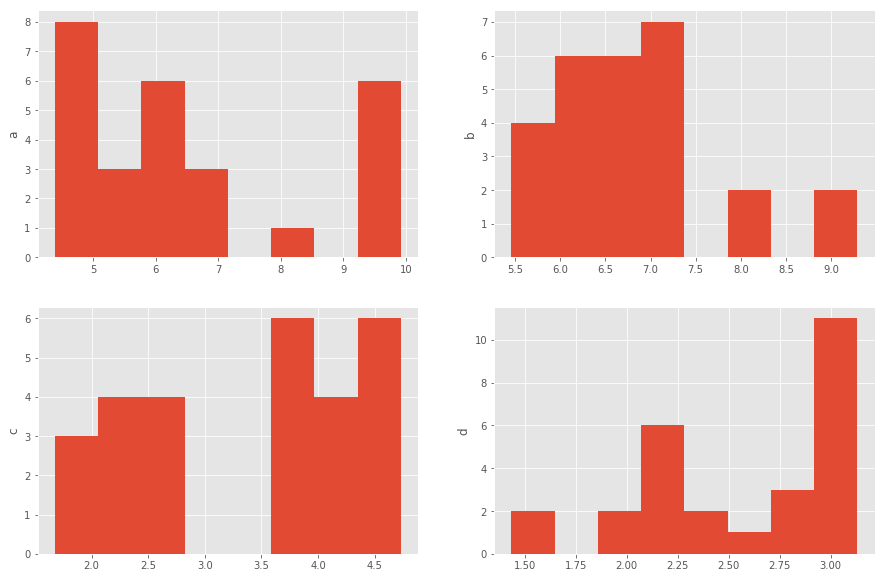

In [66]:
plt.figure(figsize=(15,10))

labels = ['a','b','c','d']
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.hist(sample[:,i],bins=8)
    plt.ylabel(labels[i])
    

In [67]:
a,b,c,d = np.mean(sample[:,0]),np.mean(sample[:,1]),np.mean(sample[:,2]),np.mean(sample[:,2])

In [68]:
a,b,c,d

(6.577970281748936, 6.836498924808203, 3.386587892712357, 3.386587892712357)

In [69]:
y_model = a*x_values_cubic**3 + b*x_values_cubic**2 + c*x_values_cubic + d

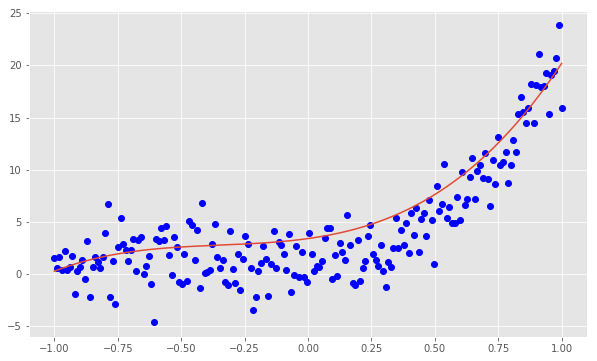

In [70]:
plt.figure(figsize=(10,6))
plt.plot(x_values_cubic,y_values_cubic,'o',color='blue')
plt.plot(x_values_cubic,y_model)